# Principal Component Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

### Load in the Labelled Dataset

In [2]:
dfR = pd.read_csv(r'dfRLabelled.csv')
dfR.head(3)

,Unnamed: 0.1,Unnamed: 0,Product,Reviewer Name,Rating,Text,Date,Country,ASIN,Language,Rules,Label
0,0,0,"Wireless Earbuds, yobola Bluetoth Earbuds, IPX...",Will of Burr,1.0 out of 5 stars,"I am a real fan of headphones, probably becaus...",11/17/2022,United States 🇺🇸,B09LCVHCVX,en,"3, 4, 5, 7 :",Suspicious
1,1,1,"Wireless Earbuds, yobola Bluetoth Earbuds, IPX...",Allen Pak,5.0 out of 5 stars,To be honest. I wasn't expecting much when I ...,10/25/2022,United States 🇺🇸,B09LCVHCVX,en,NaN,Not Suspicious
2,2,2,"Wireless Earbuds, yobola Bluetoth Earbuds, IPX...",brenda,5.0 out of 5 stars,1st off they connected very easily which is al...,11/29/2022,United States 🇺🇸,B09LCVHCVX,en,"3, 4, 6 :",Suspicious


### Remove Reviews with No Text

In [3]:
dfR = dfR[dfR['Text'].notna()]
dfR.shape

(2011, 12)

### Vectorize Reviews

In [4]:
Vectorizer = TfidfVectorizer(analyzer='word',stop_words='english', ngram_range=(1,1))
X          = Vectorizer.fit_transform(dfR.Text)
# No target y as latent semantic analysis is unsupervised.
vocabulary = pd.Series(Vectorizer.get_feature_names_out())

### PCA

In [5]:
num_components_list = list(range(1,30))
str_num_components_list = [str(i) for i in num_components_list]
component_variances = []
for component in num_components_list:
  pca = PCA(n_components = component)
  Xc = pca.fit_transform(X.toarray())
  component_variances.append(pca.explained_variance_ratio_.sum().round(3))
print(component_variances)

[0.022, 0.04, 0.052, 0.063, 0.073, 0.083, 0.093, 0.102, 0.111, 0.119, 0.127, 0.134, 0.141, 0.148, 0.155, 0.161, 0.167, 0.173, 0.179, 0.185, 0.191, 0.197, 0.202, 0.207, 0.212, 0.217, 0.222, 0.227, 0.232]


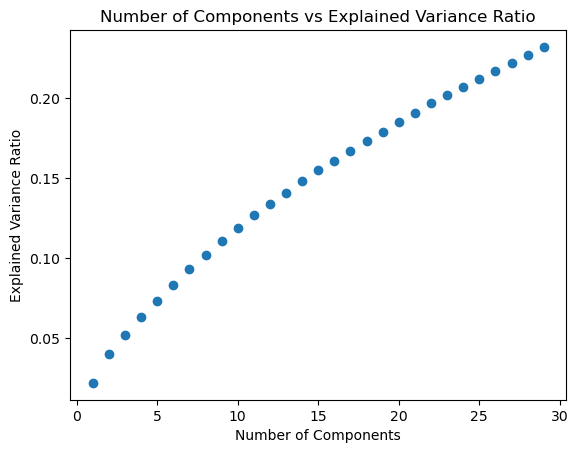

In [6]:
import matplotlib.pyplot as plt
plt.scatter(num_components_list, component_variances)
plt.title('Number of Components vs Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [7]:
Xc = pd.DataFrame(Xc)
# Allows for concatenating successfully
dfR = dfR.reset_index()
dfR_reduced = pd.concat([dfR.Text, dfR.Label,Xc],axis=1)
dfR_reduced.head(3)

,Text,Label,0,1,2,3,4,5,6,7,...,19,20,21,22,23,24,25,26,27,28
0,"I am a real fan of headphones, probably becaus...",Suspicious,-0.072694,-0.055773,0.029363,-0.054923,0.034858,-0.061904,0.053244,-0.042958,...,-0.039447,-0.132091,0.168514,-0.071237,-0.015994,-0.070916,-0.016922,0.081243,-0.013811,-0.026468
1,To be honest. I wasn't expecting much when I ...,Not Suspicious,-0.004033,0.042802,-0.062149,-0.098399,-0.059504,-0.093163,0.020079,-0.031878,...,-0.067071,-0.109942,0.107574,0.008978,-0.024604,0.047530,0.064715,0.009067,-0.079866,0.088987
2,1st off they connected very easily which is al...,Suspicious,-0.090162,-0.032244,0.017683,-0.048981,0.043000,-0.032394,0.039444,-0.020723,...,-0.016879,-0.022256,-0.032814,0.045668,-0.044853,0.002324,0.094333,-0.026447,-0.085242,-0.025675


In [8]:
k = 1
ix = [0,1,2,3,4,5,-5,-4,-3,-2,-1]
dfR_reduced.sort_values(k,ascending=False).iloc[ix,:][['Text','Label',k]].round(2)

,Text,Label,1
1804,Great Battery life and sound quality at a grea...,Not Suspicious,0.73
889,great,Suspicious,0.71
550,"Sound quality great, battery life great!!",Not Suspicious,0.70
165,Sound quality is great! Battery life is great!,Not Suspicious,0.70
1946,Great sound,Not Suspicious,0.67
583,Sound quality is great.,Not Suspicious,0.65
658,Very Good! :D,Suspicious,-0.48
1282,It’s good,Suspicious,-0.48
644,Good,Suspicious,-0.48
1421,Very good.,Suspicious,-0.48


In [9]:
# view components in terms of vocabulary
components = pca.components_

k = 1
component = pd.Series(components[k,:],index=vocabulary)
component.sort_values(ascending=False)[ix].round(2)

great         0.77
sound         0.23
price         0.21
quality       0.20
battery       0.14
life          0.14
headphones   -0.03
money        -0.03
far          -0.03
really       -0.08
good         -0.42
dtype: float64

# Logistic Regression

### Train-Test Split

In [10]:
X = dfR_reduced.drop(['Text', 'Label'], axis=1)
y = dfR.Label
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, stratify = y, random_state=0)

### Fit Model

In [11]:
# Look at regularization values
logisticRegr = LogisticRegressionCV(penalty='l1', solver='liblinear')
lrModel = logisticRegr.fit(X_train, y_train)

### Examine Coefficients

In [12]:
# Look at words associated with top components 
model_coefs = pd.Series(lrModel.coef_.ravel(), index=X_train.columns.tolist())
model_coefsDF = pd.DataFrame(model_coefs, columns = ['Coefficients'])
model_coefsDF.sort_values(by='Coefficients', ascending=False)

,Coefficients
2,4.805261
16,3.022355
5,2.547731
11,2.317580
7,2.134160
22,1.873474
3,1.589424
18,1.286459
0,1.176047
14,0.879851


Components 2 and 26 have the highest magnitude coefficients, indicating they play a strong role in the prediction process. 

### Examine Test Accuracy

In [13]:
predictions = logisticRegr.predict(X_test)

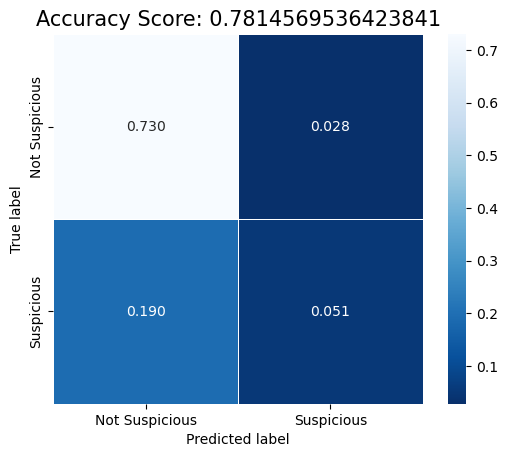

In [14]:
score = logisticRegr.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions, normalize='all')
#plt.figure(figsize=(9,9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax);
plt.ylabel('True label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
ax.xaxis.set_ticklabels(['Not Suspicious', 'Suspicious']); ax.yaxis.set_ticklabels(['Not Suspicious', 'Suspicious']);